In [453]:
import joblib
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy.stats import pearsonr
from itertools import chain

from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import median_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, Adagrad, RMSprop
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

pd.set_option('max_columns', 120)

%matplotlib inline

LAGS = [5, 10, 20, 30, 40]

In [426]:
def mean_prediction_score(RUL_real, RUL_pred):
    d = RUL_pred - RUL_real
    
    return (np.sum(np.exp(d[d >= 0] / 13) - 1) +
            np.sum(np.exp(-1 * d[d < 0] / 10) - 1)) / len(RUL_real)

## Data Preparation

In [145]:
def add_total_cycles(data):
    data = data[list(range(0, 26))].rename(columns= {0: 'unit', 1: 'cycle'})
    total_cycles = data.groupby(['unit']).agg({'cycle': 'max'}).reset_index()
    total_cycles = total_cycles.rename(columns={'cycle': 'total_cycles'})
    return data.merge(total_cycles, how='left', left_on='unit', right_on='unit')

def load_train_data(data_name):
    data = pd.read_csv('data/train_{}.txt'.format(data_name), sep=' ', header=None)
    data = add_total_cycles(data)
    data['RUL'] = data.apply(lambda r: int(r['total_cycles'] - r['cycle']), axis=1)
    
    return data

def load_test_data(data_name):
    data = pd.read_csv('data/test_{}.txt'.format(data_name), sep=' ', header=None)
    data = add_total_cycles(data)
    
    rul = pd.read_csv('data/RUL_{}.txt'.format(data_name), sep=' ', header=None)
    rul = rul[list(range(0, 1))]
    rul['unit'] = list(range(1, len(rul) + 1))
    rul = rul.rename(columns = {0: 'RUL'})
    
    data = data.merge(rul, how='left', left_on='unit', right_on='unit')
    
    data['total_cycles'] = data.apply(lambda r: int(r['total_cycles'] + r['RUL']), axis=1)
    data['RUL'] = data.apply(lambda r: int(r['total_cycles'] - r['cycle']), axis=1)
    
    return data

## Feature Engineering

In [81]:
def get_row_lags(unit_data, i, feature_cols):
    periods = LAGS
    ix = [i] + [i - period for period in periods]
    return unit_data.loc[ix, feature_cols].values, unit_data.loc[i, 'RUL']

def get_lagged_unit_data(data, unit, feature_cols):
    periods = LAGS
    unit_data = data[data['unit'] == unit].sort_values(
        by=['cycle'], ascending=True).reset_index(drop=True)

    lagged_unit_data = [get_row_lags(unit_data, i, feature_cols)
                        for i in range(max(periods), len(unit_data))]
    
    return lagged_unit_data

def get_lagged_data(data, feature_cols):
    
    lagged_data = chain(*[shift_unit_data(data, unit, feature_cols)
                          for unit in data['unit'].unique()])
    
    measurement, rul = zip(*list(lagged_data))
    return np.array(measurement), np.array(rul)
    

In [363]:
dataset_name = 'FD004'

feature_cols = range(2, 26)
col_dict = {c: 'f{}'.format(c) for c in feature_cols}
feature_cols = [v for _, v in col_dict.items()]

train = load_train_data(dataset_name).rename(columns=col_dict)
test = load_test_data(dataset_name).rename(columns=col_dict)

scaler = StandardScaler()
pca = PCA(n_components=len(feature_cols))

train.loc[:, feature_cols] = scaler.fit_transform(train.loc[:, feature_cols])
train.loc[:, feature_cols] = pca.fit_transform(train.loc[:, feature_cols])

test.loc[:, feature_cols] = scaler.transform(test.loc[:, feature_cols])
test.loc[:, feature_cols] = pca.transform(test.loc[:, feature_cols])

x_train, y_train = get_lagged_data(train, feature_cols)
x_test, y_test = get_lagged_data(test, feature_cols)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train)

## LSTM Regressor

In [315]:
def neural_factory(network_depth, dense_size, dropout_rate, reg_lambda, learning_rate):

    kernel_initializer = 'glorot_uniform'
    input_layer = l = Input(shape=x_train.shape[1:], name='components')
    
    l = LSTM(64, name='lstm', kernel_regularizer=L1L2(reg_lambda, reg_lambda))(l)
    l = Dropout(dropout_rate, name='dropout_lstm')(l)
    
    for i in range(max(1, network_depth)):
        l = Dense(dense_size,
                  activation='relu',
                  name='hidden_{}'.format(i),
                  kernel_initializer=kernel_initializer,
                  kernel_regularizer=L1L2(reg_lambda, reg_lambda))(l)
        l = Dropout(dropout_rate, name='dropout_{}'.format(i))(l)
   
    rul_layer = Dense(1, name='rul_prediction')(l)
    model = Model(inputs=[input_layer], outputs=[rul_layer], name='rlu_estimator')
    opt = Adam(lr=learning_rate)
    model.compile(loss='mse', optimizer=opt, metrics=['mae'])
        
    return model

def random_search(x_train, y_train, x_val, y_val, batch_size=32, epochs=2):
    
    param_grid = {
      'network_depth': [1, 2, 3],
      'dense_size': [32, 64, 128],
      'dropout_rate': [0.1, 0.3],
      'reg_lambda': [0.1, 0.2],
      'learning_rate': [0.001, 0.01]}

    model = KerasRegressor(build_fn=neural_factory, verbose=0)
    rs_keras = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
        scoring='neg_mean_squared_error', n_iter=5, cv=2, n_jobs=1, verbose=1)

    rs_keras.fit(
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

    for param, value in rs_keras.best_params_.items():
        print('{}: {}'.format(param, value))                 
    
    return rs_keras.best_params_

In [132]:
best_params = random_search(x_train, y_train, x_val, y_val)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.9min finished


reg_lambda: 0.1
network_depth: 1
learning_rate: 0.01
dropout_rate: 0.3
dense_size: 32


In [182]:
model_nn.summary()

Model: "rlu_estimator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
components (InputLayer)      [(None, 6, 24)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                22784     
_________________________________________________________________
dropout_lstm (Dropout)       (None, 64)                0         
_________________________________________________________________
hidden_0 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_0 (Dropout)          (None, 64)                0         
_________________________________________________________________
hidden_1 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)              

In [304]:
best_params = {
    'reg_lambda': 0.6,
    'network_depth': 3,
    'learning_rate': 0.01,
    'dropout_rate': 0.5,
    'dense_size': 64}

In [316]:
def annealing(epoch):
    lr = 0.01
    annealing_start = 5
    return lr if epoch < annealing_start else lr * np.exp(0.1 * (annealing_start - epoch))

model_nn = neural_factory(**best_params)
callbacks = [
    EarlyStopping(patience=8, verbose=1),
    LearningRateScheduler(annealing, verbose=1)]

In [317]:
history = model_nn.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32,
    epochs=25, callbacks=callbacks, verbose=1)
# model_nn.save('models/lstm.h5')

Train on 38466 samples, validate on 12823 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/25
38466/38466 [==============================] - 13s 347us/sample - loss: 5262.3393 - mae: 48.9557 - val_loss: 3595.3297 - val_mae: 40.3075

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
Epoch 2/25
38466/38466 [==============================] - 11s 281us/sample - loss: 4433.7923 - mae: 45.5814 - val_loss: 3513.5369 - val_mae: 40.2134

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
Epoch 3/25
38466/38466 [==============================] - 11s 274us/sample - loss: 4206.9651 - mae: 44.4922 - val_loss: 3359.2890 - val_mae: 37.7488

Epoch 00004: LearningRateScheduler reducing learning rate to 0.01.
Epoch 4/25
38466/38466 [==============================] - 11s 275us/sample - loss: 4083.4125 - mae: 43.9728 - val_loss: 3310.7940 - val_mae: 39.1233

Epoch 00005: LearningRateScheduler reducing learning rate to 0.01.
Epoch 5/25
384

In [318]:
def evaluate_model(model, x, y):
    y_pred = model.predict(x).reshape(-1)
    print('Mean Prediction Score:', mean_prediction_score(y, y_pred))
    print('Mean squared Error:', mean_squared_error(y, y_pred))
    print('Median absolute error:', median_absolute_error(y, y_pred))
    print('R2:', r2_score(y, y_pred))

In [319]:
evaluate_model(model_nn, x_val, y_val)

Mean Prediction Score: 77992654687.77267
Mean squared Error: 2357.5739505908073
Median absolute error: 24.057552337646484
R2: 0.6443404335379431


In [320]:
evaluate_model(model_nn, x_train, y_train)

Mean Prediction Score: 85467920868.20206
Mean squared Error: 2326.000991182022
Median absolute error: 24.356884956359863
R2: 0.6468144505431389


In [321]:
evaluate_model(model_nn, x_test, y_test)

Mean Prediction Score: 85806440552.35252
Mean squared Error: 4627.465554746217
Median absolute error: 35.345863342285156
R2: 0.4036198257258927


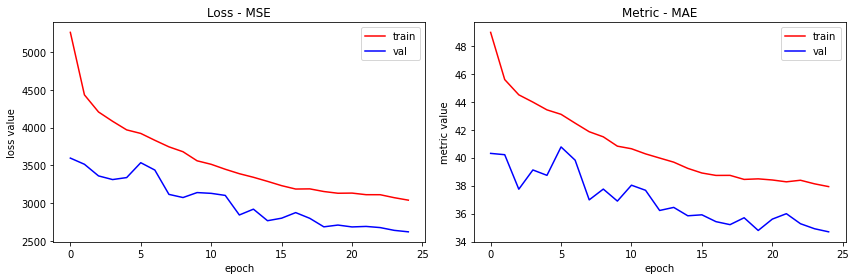

In [457]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(model_nn.history.history['loss'], 'r', label='train')
ax[0].plot(model_nn.history.history['val_loss'], 'b', label='val')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss value')
ax[0].set_title('Loss - MSE')
ax[0].legend()

ax[1].plot(model_nn.history.history['mae'], 'r', label='train')
ax[1].plot(model_nn.history.history['val_mae'], 'b', label='val')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('metric value')
ax[1].set_title('Metric - MAE')
ax[1].legend()

plt.tight_layout()
plt.savefig('img/lstm_history.svg')
plt.show()

## Support Vector Machine

In [340]:
x_train_svr, y_train_svr = train[feature_cols], train['RUL']
x_test_svr, y_test_svr = test[feature_cols], test['RUL']

model_svr = SVR()
model_svr.fit(x_train_svr, y_train_svr)
# joblib.dump(m, 'models/svr.pickle')

['model/svr.pickle']

In [341]:
evaluate_model(model_svr, x_test_svr, y_test_svr)

Mean Prediction Score: 164912304965476.56
Mean squared Error: 9943.116916110299
Median absolute error: 52.945778726023256
R2: -0.1704803281493421


In [342]:
evaluate_model(model_svr, x_train_svr, y_train_svr)

Mean Prediction Score: 135645746912962.03
Mean squared Error: 5894.394025842888
Median absolute error: 45.23965439652008
R2: 0.26876956044772526


## Visualization

In [369]:
y_pred = model_nn.predict(x_test)
y_pred_svr = model_svr.predict(x_test_svr)

In [436]:
err_lstm = np.abs(y_pred_lstm.flatten() - y_test)
err_svr = np.abs(y_pred_svr - y_test_svr)

lstm_corr = pd.DataFrame({'true': y_test, 'pred': y_pred.flatten()}).sample(1000)
svr_corr = pd.DataFrame({'true': y_test_svr, 'pred': y_pred_svr}).sample(1000)

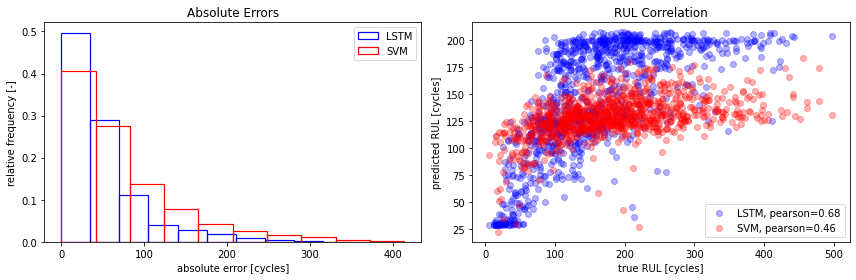

In [460]:
def get_w(x):
    return np.zeros_like(x) + 1. / x.size
    
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].hist(
    err_lstm,
    edgecolor='b',
    weights=get_w(err_lstm),
    linewidth=1.2,
    fill=False,
    label='LSTM')

ax[0].hist(
    err_svr,
    edgecolor='r',
    weights=get_w(err_svr),
    linewidth=1.2,
    fill=False,
    label='SVM')

ax[0].set_xlabel('absolute error [cycles]')
ax[0].set_ylabel('relative frequency [-]')
ax[0].set_title('Absolute Errors')
ax[0].legend(loc='upper right')

pearson_lstm = pearsonr(lstm_corr['true'], lstm_corr['pred'])[0]
pearson_svr = pearsonr(svr_corr['true'], svr_corr['pred'])[0]

ax[1].scatter(
    lstm_corr['true'],
    lstm_corr['pred'],
    color='b',
    alpha=0.3,
    label=f'LSTM, pearson={pearson_lstm:.2f}')

ax[1].scatter(
    svr_corr['true'],
    svr_corr['pred'],
    color='r',
    alpha=0.3,
    label=f'SVM, pearson={pearson_svr:.2f}')

ax[1].set_xlabel('true RUL [cycles]')
ax[1].set_ylabel('predicted RUL [cycles]')
ax[1].set_title('RUL Correlation')
ax[1].legend(loc='lower right')

plt.tight_layout()
plt.savefig('img/comparison.svg')
plt.show()